In [282]:
import math
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import matplotlib.ticker as mtick
from matplotlib.lines import Line2D
from matplotlib import markers

from matplotlib.cm import get_cmap
from matplotlib.gridspec import GridSpec

import warnings
warnings.filterwarnings('ignore')
warnings.simplefilter('ignore')



# Constants

In [283]:
url = 'https://docs.google.com/spreadsheets/d/1b3FXkZw8Vi5j9aCXeQElq08aSglCZ7A6AzHz_rPTU5U/edit#gid=1908014063'
data_path = 'datasets/dataset5.csv'

cmap = get_cmap('Set2')
cmap_paired = get_cmap('Paired')

sns.set(style="whitegrid", font_scale=1)

xticklabels = {
    'data_experiment': 'D_ED',
    'data_ground_truth': 'D_GT',
    'data_params': 'D_PAR',
    'data_version': 'D_VER',
    'experiment_exp_source_code': 'E_ESC',
    'experiment_external_source_code': 'E_EXT',
    'experiment_hw': 'E_HW',
    'experiment_ref_source_code': 'E_REF', 
    'experiment_results': 'E_RES',
    'experiment_runtime': 'E_RT', 
    'experiment_setup': 'E_STP',
    'experiment_source_code': 'E_SC',
    'experiment_sw': 'E_SD', 
    'method_contribution': 'M_RQ',
    'method_objective': 'M_OBJ',
    'method_params': 'M_PS', 
    'method_params_description': 'M_PD', 
    'method_problem': 'M_PB',
    'method_pseudo_code': 'M_PC', 
    'method_research': 'M_RM', 
    'method_workflow': 'M_WF'   
}

tasks_dict = {
    'ER': 'Entity Resolution',
    'EM': 'Entity Matching',
    'SMAT': 'Schema Matching',
    'SMAP': 'Schema Mapping'
}

repro_dict = {
    'method_repro': 'R3D',
    'data_repro': 'R2D',
    'experiment_repro': 'R1D'
}

task_color = {
    'EM': cmap(0),
    'ER': cmap(2),
    'SMAP': cmap(5),
    'SMAT': cmap(7),
}

experiment_dict = {
    'experiment_source_code': 'Source code',
    'experiment_exp_source_code': 'Experiment\n source code',
    'experiment_external_source_code': 'External\n source code', 
    'experiment_hw': 'Harware', 
    'experiment_runtime': 'Runtime',
    'experiment_setup': 'Setup',
}

data_dict = {
    'data_experiment': 'Dataset', 
    'data_ground_truth': 'Ground\n truth',
    'data_params': 'Export\n parameters',
    'data_version': 'Version'
}

method_dict = {
    'method_contribution': 'Research\n questions',
    'method_objective': 'Objective',
    'method_problem': 'Problem',
    'method_research': 'Research\n methodology', 
    'method_pseudo_code': 'Pseudo-code',
    'method_params': 'Params\n value',
    'method_params_description': 'Params\n description'
}


m_d = {i:item[1] for i, item in enumerate(method_dict.items())}
d_d = {i:item[1] for i, item in enumerate(data_dict.items())}
e_d = {i:item[1] for i, item in enumerate(experiment_dict.items())}

# Helper functions

In [295]:
interval = [2000, 2010, 2020]
ranges = [0, 0.5, 0.99, 1]



def repro_count_per_task(dataframe, task):
    dataframe['intervals'] = experiment_per_task['intervals']
    dataframe['R1D'] = experiment_per_task[task]
    dataframe['R2D'] = data_per_task[task]
    dataframe['R3D'] = method_per_task[task]
    return dataframe

def interval_count(dataframe, column_name, ranges=[0,0.5,0.99, 1]):
    aux = dataframe.groupby(pd.cut(dataframe[column_name], ranges)).count()['interval'].reset_index()
    intervals = aux[column_name]
    counts = aux['interval'].apply(lambda x: x * 100 / dataframe.shape[0]).round(1)
    
    return counts, intervals

def append_column_true_values(dataframe, append_to, column_name): 
    aux = dataframe.groupby([column_name, 'year']).count()['number'].reset_index()
    
    return append_to.append(aux[aux[column_name] == True])


def plot_variable_percentage_intervals(dataframe, columns, interval, color=[]):
    aux = pd.DataFrame()

    for c in columns:
        aux = append_column_true_values(dataframe, aux, c)


    aux_plot = pd.melt(aux, ['year', 'number']).dropna().drop(['value'], axis=1).pivot(index='year', columns='variable')['number'].reset_index()

    aux_split_interval = aux_plot.groupby([pd.cut(aux_plot['year'], interval)]).sum()[columns]
    aux_split_interval.iloc[0] = aux_split_interval.iloc[0].transform(lambda x: x * 10)
    aux_split_interval.iloc[1] = aux_split_interval.iloc[1].transform(lambda x: x * 100 / 18)
    
    if len(color) > 0:
        ax = aux_split_interval.reset_index().plot(x='year', kind='barh', color=color, width=0.35)
    else:
        ax = aux_split_interval.reset_index().plot(x='year', kind='bar', colormap=cmap_paired, align='center')
    
    return ax
    
    
def plot_variable_percentage_intervals_horizontal(dataframe, columns, y_pos_dict, ax, interval=interval):
    aux = pd.DataFrame()

    for c in columns:
        aux = append_column_true_values(dataframe, aux, c)


    aux_plot = pd.melt(aux, ['year', 'number']).dropna().drop(['value'], axis=1).pivot(index='year', columns='variable')['number'].reset_index()

    aux_split_interval = aux_plot.groupby([pd.cut(aux_plot['year'], interval)]).sum()[columns]
    aux_split_interval.iloc[0] = aux_split_interval.iloc[0].transform(lambda x: x * 10)
    aux_split_interval.iloc[1] = aux_split_interval.iloc[1].transform(lambda x: x * 100 / 18)
    aux_split_interval.reset_index(inplace=True)

    y_pos = range(0, aux_split_interval.shape[1]-1)
    
    height = 0.7
    
    ax.barh(y_pos, -aux_split_interval.iloc[0, 1:], color=cmap_paired(8), height=height)
    ax.barh(y_pos, aux_split_interval.iloc[1, 1:], color=cmap_paired(6), height=height)

    ax.set_yticks(y_pos)
    ax.set_yticklabels(y_pos_dict.values(), fontdict={'fontsize': 'medium'})
    
    for i, v in enumerate(aux_split_interval.iloc[0, 1:].to_numpy()):
        ax.text(-v - 50, i, '{:.1f}%'.format(v), fontdict={'fontsize': 'medium'})

    for i, v in enumerate(aux_split_interval.iloc[1, 1:].to_numpy()):
        ax.text(v + 7, i, '{:.1f}%'.format(v), fontdict={'fontsize': 'medium'})

    ax.set_xlim([-155, 160])
    ax.set_xticklabels([])
    ax.grid(False)
    
    return ax

    




# Data

In [296]:
df = pd.read_csv(data_path).drop(['D_REPRO_CHECK', 'M_REPRO_CHECK', 'E_REPRO_CHECK'], axis=1)
df = df.replace('PVLDB', 'VLDB')

task_count = df.groupby('task').count()['name']

grouped_df = df.drop(['number', 'year', 'venue', 'method_repro', 'data_repro', 'experiment_repro', 'experiment_results'], axis=1)
grouped_df = pd.melt(grouped_df, ['name', 'task'])

grouped_df['value'] = grouped_df['value'].fillna('N/A')
grouped_df['repro'] = grouped_df['variable']
grouped_df['repro'] = grouped_df['repro'].replace(to_replace=r'^data_.*$', value='data', regex=True)
grouped_df['repro'] = grouped_df['repro'].replace(to_replace=r'^method_.*$', value='method', regex=True)
grouped_df['repro'] = grouped_df['repro'].replace(to_replace=r'^experiment_.*$', value='experiment', regex=True)


grouped_df = grouped_df.groupby(['task', 'variable', 'repro', 'value'])['name'].aggregate('count').unstack().reset_index()


grouped_by_year = df.groupby(['year', 'task'])['name'].aggregate('count').unstack().fillna(0).reset_index()
grouped_by_venue = df.groupby(['venue', 'task'])['name'].aggregate('count').unstack().fillna(0).reset_index()


repro_per_year = df[['year', 'method_repro', 'data_repro','experiment_repro']]
repro_per_year = pd.melt(repro_per_year, ['year'], var_name='repro')
repro_per_year = repro_per_year.pivot_table(index = ['repro',
                        repro_per_year.groupby(['repro','year']).cumcount()],
               columns = 'year',
               values = 'value').reset_index()


repro_per_venue = df[['venue', 'method_repro', 'data_repro','experiment_repro']]
repro_per_venue = pd.melt(repro_per_venue, ['venue'], var_name='repro')
repro_per_venue = repro_per_venue.pivot_table(index = ['repro',
                        repro_per_venue.groupby(['repro','venue']).cumcount()],
               columns = 'venue',
               values = 'value').reset_index().drop(['level_1'], axis=1)

repro_per_task = df.groupby('task').aggregate('mean')[['method_repro', 'data_repro', 'experiment_repro']].reset_index()


repro_count_em = repro_count_per_task(pd.DataFrame(), 'EM')
repro_count_er = repro_count_per_task(pd.DataFrame(), 'ER')
repro_count_smat = repro_count_per_task(pd.DataFrame(), 'SMAT')
repro_count_smap = repro_count_per_task(pd.DataFrame(), 'SMAP')

em = grouped_df[grouped_df['task'] == 'EM'].drop(['task'], axis=1)
er = grouped_df[grouped_df['task'] == 'ER'].drop(['task'], axis=1)
smap = grouped_df[grouped_df['task'] == 'SMAP'].drop(['task'], axis=1)
smat = grouped_df[grouped_df['task'] == 'SMAT'].drop(['task'], axis=1)

data_df = df[['name', 'data_experiment', 'data_ground_truth', 'data_params', 'data_version']]

experiment_df = df[['name', 'experiment_source_code',
       'experiment_external_source_code', 'experiment_exp_source_code',
       'experiment_setup', 'experiment_hw', 'experiment_runtime']]

method_df = df[['name', 'method_problem',
       'method_objective', 'method_contribution',
       'method_research', 'method_pseudo_code', 'method_params',
       'method_params_description']]



# Plots

## Distribution of tasks per year and venue

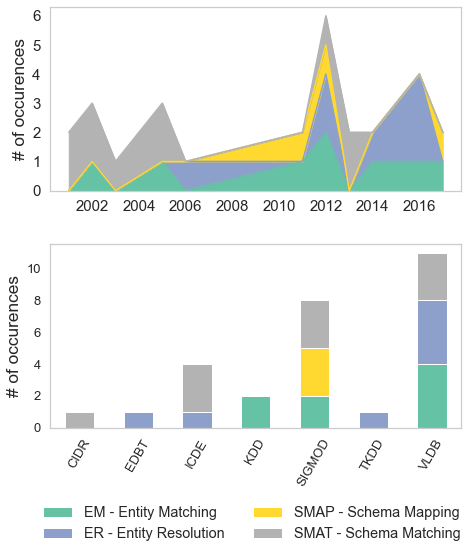

In [134]:
fig, axs = plt.subplots(2, 1, figsize=(7, 7))
fig.tight_layout(pad=2.5)
fontsize=15

axis1 = grouped_by_year.plot.area(x='year', ax=axs[0], fontsize=fontsize, colormap=cmap)
# axis1 = grouped_by_year.plot(x='year', kind='bar', stacked=True, ax=axs[0], fontsize=13, colormap=cmap)
# axis1.grid(color='grey', linestyle='-', linewidth=0.2)
axis1.grid(False)
axis1.set_xlabel('')
axis1.set_ylabel('# of occurences', fontsize='x-large')
# axis1.set_xticklabels(axis1.get_xticklabels(), rotation='60')
axis1.set_axisbelow(True)
axis1.get_legend().remove()

# axis2 = grouped_by_venue.plot.area(x='venue', ax=axs[1], fontsize=fontsize, colormap=cmap)
axis2 = grouped_by_venue.plot(x='venue', kind='bar', stacked=True, ax=axs[1], fontsize=13, colormap=cmap)
# axis2.grid(color='grey', linestyle='-', linewidth=0.2)
axis2.grid(False)
axis2.set_xlabel('')
axis2.set_ylabel('# of occurences', fontsize='x-large')
axis2.set_xticklabels(axis2.get_xticklabels(), rotation='60')
axis2.set_yticks(range(0, 12, 2))
axis2.set_axisbelow(True)

h, l = axis2.get_legend_handles_labels()
labels = ['EM - Entity Matching', 'ER - Entity Resolution', 'SMAP - Schema Mapping', 'SMAT - Schema Matching']

# axis2.legend(h, labels, loc=(0, -0.55), ncol=2, fontsize='large', mode='expand')
axis2.legend(h, labels, loc=(-0.03, -0.65), ncol=2, fontsize='large', frameon=False)


plt.savefig('plots/distribution-venue-year.pdf', dpi=300, bbox_inches = "tight")


## Distribution of papers per task

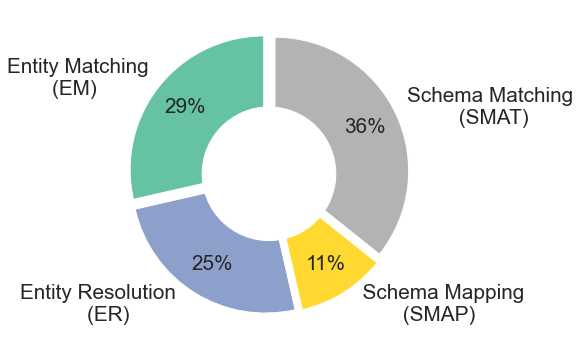

In [285]:
d = {
    'EM': 'Entity Matching\n(EM)         ',
    'ER': 'Entity Resolution  \n(ER)          ',
    'SMAT': 'Schema Matching\n         (SMAT)',
    'SMAP': '  Schema Mapping\n         (SMAP)'
}

plt.figure(figsize=(25, 5))

pie_data = df.groupby('task')['name'].aggregate('count').reset_index()
pie_data['task'] = pie_data['task'].apply(lambda x: d[x])
pie_data = pie_data.set_index('task').iloc[:,0]

explode = (0.05,0.05,0.05,0.05)

axis = pie_data.plot.pie(autopct='%1.0f%%', colormap=cmap, fontsize='xx-large',
                         startangle=90, pctdistance=0.75, explode=explode, textprops={'fontweight': 550})

centre_circle = plt.Circle((0,0),0.50,fc='white')
fig = plt.gcf()
fig.gca().add_artist(centre_circle)
plt.tight_layout()

axis.set_ylabel('')

plt.savefig('plots/distribution-papers.pdf', dpi=300, bbox_inches = "tight")



## The percentage of true and false values for each variable per total number of papers in atask

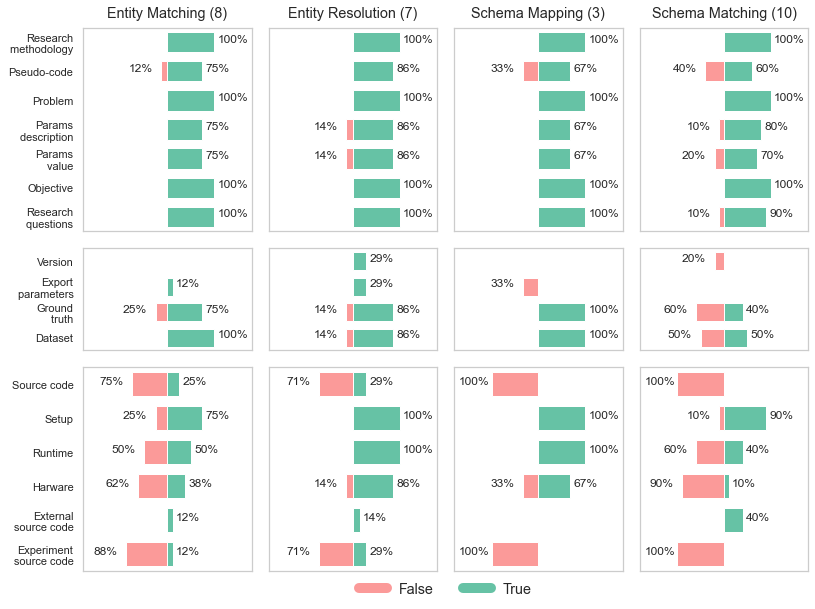

In [289]:
height = 0.7
sns.set_style({'axes.grid': False})
    
fig = plt.figure(figsize=(13, 10))
fig.subplots_adjust(wspace=0.1, hspace=0.1)

cols = 4
rows = 3
ylabel_font = 13

spec = GridSpec(ncols=cols, nrows=rows, width_ratios=[2, 2, 2, 2], height_ratios=[2, 1, 2])

axs = list()
for i in range(0, cols * rows, cols):
    ax = list()
    for j in range(i, i + cols):
        ax.append(fig.add_subplot(spec[j]))
    axs.append(ax)


def plot_per_task(dataframe, axs, axis_nr, axis_off=False):
    
    repro_types = ['method', 'data', 'experiment']
    
    for i, t in enumerate(repro_types):
        df = pd.melt(dataframe[dataframe['repro'] == t].drop(['repro', 'N/A'], axis=1),
                          ['variable'], value_vars=[True, False], value_name='count').pivot(index='value', columns='variable')['count'].reset_index()

        y_pos = list(df.columns[1:])
        axs[i][axis_nr].barh(y_pos, -df.iloc[0, 1:], color=cmap_paired(4), height=height)
        axs[i][axis_nr].barh(y_pos, df.iloc[1, 1:], color=cmap(0), height=height)
        axs[i][axis_nr].set_ylim([-0.5, len(y_pos)-0.5])
        axs[i][axis_nr].set_yticklabels(y_pos)
    
        for j, v in enumerate(df.iloc[0, 1:].to_numpy()):
            if math.isnan(v) or math.isnan(j):
                continue
            axs[i][axis_nr].text(-round(v) - 70, j, '{:.0f}%'.format(v), fontdict={'fontsize': 'medium'})

        for j, v in enumerate(df.iloc[1, 1:].to_numpy()):
            if math.isnan(v) or math.isnan(j):
                continue
            axs[i][axis_nr].text(round(v) + 7, j, '{:.0f}%'.format(v), fontdict={'fontsize': 'medium'})
    
        for ax in axs:
            ax[axis_nr].set_xlim([-180, 180])
            ax[axis_nr].set_xticks([])

        if axis_off:
            for ax in axs:
                ax[axis_nr].set_yticks([])


plot_per_task(em, axs, 0)
plot_per_task(er, axs, 1, True)
plot_per_task(smat, axs, 3, True)
plot_per_task(smap, axs, 2, True)

axs[0][0].set_yticklabels([method_dict[x.get_text()] for x in axs[0][0].get_yticklabels()],
                          fontdict={'fontsize': 11})       
axs[1][0].set_yticklabels([data_dict[x.get_text()] for x in axs[1][0].get_yticklabels()], 
                          fontdict={'fontsize': 11})
axs[2][0].set_yticklabels([experiment_dict[x.get_text()] for x in axs[2][0].get_yticklabels()],
                          fontdict={'fontsize': 11})

title_padding = 10
axs[0][0].set_title('Entity Matching ({})'.format(task_count['EM']), fontsize='large',pad=title_padding)
axs[0][1].set_title('Entity Resolution ({})'.format(task_count['ER']), fontsize='large', pad=title_padding)
axs[0][3].set_title('Schema Matching ({})'.format(task_count['SMAT']), fontsize='large', pad=title_padding)
axs[0][2].set_title('Schema Mapping ({})'.format(task_count['SMAP']), fontsize='large', pad=title_padding)

plt.legend(handles=[Line2D([], [], color= cmap_paired(4), linestyle='-', linewidth=10, label='False'),
                   Line2D([], [], color= cmap(0), linestyle='-', linewidth=10, label='True')],
                ncol=2, loc=(-1.7, -0.15), fontsize='large', frameon=False)

plt.savefig('plots/distribution-task-variable.pdf', dpi=300, bbox_inches='tight')




## The percentage of papers that mention N percentage of variables per reproducibility type

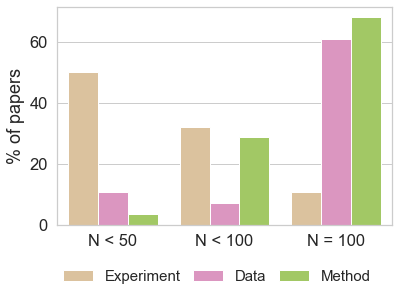

In [277]:

e = experiment_df.drop(['name'], axis=1).fillna('0').apply(lambda x: x.value_counts(), axis=1).apply(lambda x: x * 100 / 5).assign(interval='')
m = method_df.drop(['name'], axis=1).fillna('N/A').apply(lambda x: x.value_counts(), axis=1).apply(convert, args=[7], axis=1).assign(interval='')
d = data_df.drop(['name'], axis=1).fillna('N/A').apply(lambda x: x.value_counts(), axis=1).apply(convert, args=[4], axis=1).assign(interval='')

ranges = [0, 50, 99, 100]


aux = interval_count(e, True, ranges)

interval_df = pd.DataFrame(columns=['interval', 'method_repro', 'data_repro', 'experiment_repro'])
interval_df.loc[:, 'interval'] = aux[1]
interval_df.loc[:, 'experiment_repro'] = aux[0]
interval_df.loc[:, 'method_repro'] = interval_count(m, True, ranges)[0]
interval_df.loc[:, 'data_repro'] = interval_count(d, True, ranges)[0]

def convert(x, n):
    if math.isnan(float(x['N/A'])):
        return x * 100 / n
    else:
        return (x * 100 / (n - int(x['N/A'])))
    

sns.set(style="whitegrid", font_scale=1.5)
ax = sns.barplot(x='interval', y='value', hue='variable', data=pd.melt(interval_df, ['interval']), 
            hue_order=['experiment_repro', 'data_repro', 'method_repro'], palette=[cmap(6), cmap(3), cmap(4)])

ax.set_xticklabels(['N < 50', 'N < 100', 'N = 100'])
ax.set_xlabel('')
ax.set_ylabel('% of papers')

handles, labels = ax.get_legend_handles_labels()
ax.legend(handles, ['Experiment', 'Data', 'Method'], loc=(0,-0.3), ncol=3, fontsize='small', mode='expand', frameon=False)

plt.savefig('plots/barchart-repro.pdf', dpi=300, bbox_inches='tight')




## The percentage of papers with true values for each variable per total number of papers in a year interval

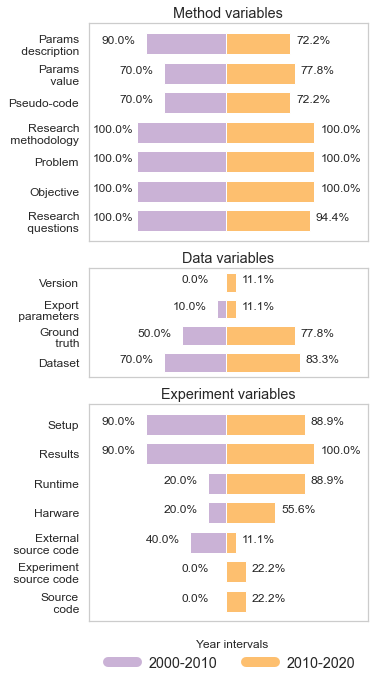

In [346]:

fig = plt.figure(figsize=(5, 11))
fig.subplots_adjust(hspace=0.15)

cols = 1
rows = 3

spec = GridSpec(ncols=cols, nrows=rows, width_ratios=[1], height_ratios=[1, 0.5, 1])

axs = list()
for i in range(0, cols * rows, cols):
    axs.append(fig.add_subplot(spec[i]))

# fig, axs = plt.subplots(3, 1, figsize=(5, 14))

plot_variable_percentage_intervals_horizontal(df, method_dict.keys(), m_d, axs[0])
plot_variable_percentage_intervals_horizontal(df, data_dict.keys(), d_d, axs[1])
plot_variable_percentage_intervals_horizontal(df, experiment_dict.keys(), e_d, axs[2])

axs[0].set_title('Method variables', fontsize='large')
axs[1].set_title('Data variables', fontsize='large')
axs[2].set_title('Experiment variables', fontsize='large')


plt.legend(handles=[Line2D([], [], color= cmap_paired(8), linestyle='-', linewidth=10, label='2000-2010'),
                   Line2D([], [], color= cmap_paired(6), linestyle='-', linewidth=10, label='2010-2020')],
                ncol=4, loc=(0.05, -0.25), fontsize='large', title='Year intervals', frameon=False)


plt.savefig('plots/diverging-variables.pdf', dpi=300, bbox_inches='tight')



# Statistics

## General statistics

In [291]:
columns = ['data_experiment', 'data_ground_truth', 'data_version',
                'experiment_source_code', 'experiment_external_source_code',
               'experiment_exp_source_code', 'experiment_hw', 'experiment_runtime', 'experiment_setup',
               'method_params', 'method_params_description']

stats = df[columns].fillna('N/A')
# Added extra column outside the index and set the index to all the columns for the count function
stats = stats.assign(occr='').set_index(columns)

# New dataset to store the percentages 
pctg_code_data = pd.DataFrame(columns=columns)
# Added a new index with the boolean values and 'N/A'
pctg_code_data = pctg_code_data.assign(value=[True, False, 'N/A']).set_index('value')

cols = pctg_code_data.columns
# count the values for each column and store it in the new df
for col in cols:
    pctg_code_data.loc[:, col] = stats.count(level=col)['occr'] 

# Transform in percentage with 1 decimal
pctg_code_data = pctg_code_data.fillna(0).apply(lambda x: x * 100 / df.shape[0]).round(1)

transp = pctg_code_data.transpose().reset_index()

display(transp)
display(pctg_code_data)

value,index,True,False,N/A
0,data_experiment,78.6,21.4,0.0
1,data_ground_truth,67.9,32.1,0.0
2,data_version,7.1,7.1,85.7
3,experiment_source_code,14.3,85.7,0.0
4,experiment_external_source_code,21.4,0.0,78.6
5,experiment_exp_source_code,10.7,89.3,0.0
6,experiment_hw,42.9,57.1,0.0
7,experiment_runtime,64.3,35.7,0.0
8,experiment_setup,89.3,10.7,0.0
9,method_params,75.0,10.7,14.3


,data_experiment,data_ground_truth,data_version,experiment_source_code,experiment_external_source_code,experiment_exp_source_code,experiment_hw,experiment_runtime,experiment_setup,method_params,method_params_description
value,,,,,,,,,,,
True,78.6,67.9,7.1,14.3,21.4,10.7,42.9,64.3,89.3,75.0,78.6
False,21.4,32.1,7.1,85.7,0.0,89.3,57.1,35.7,10.7,10.7,7.1
N/A,0.0,0.0,85.7,0.0,78.6,0.0,0.0,0.0,0.0,14.3,14.3


## Statistics about R1D, R2D, R3D

In [197]:
sel = df[['method_repro', 'data_repro', 'experiment_repro']]
sel = sel.assign(interval='')

aux = interval_count(sel, 'experiment_repro')

pctg_rd = pd.DataFrame(columns=['interval', 'method_repro', 'data_repro', 'experiment_repro'])
pctg_rd.loc[:, 'interval'] = aux[1]
pctg_rd.loc[:, 'experiment_repro'] = aux[0]
pctg_rd.loc[:, 'method_repro'] = interval_count(sel, 'method_repro')[0]
pctg_rd.loc[:, 'data_repro'] = interval_count(sel, 'data_repro')[0]


display(pctg_rd)

,interval,method_repro,data_repro,experiment_repro
0,"(0.0, 0.5]",3.6,21.4,3.6
1,"(0.5, 0.99]",28.6,32.1,89.3
2,"(0.99, 1.0]",67.9,46.4,7.1


# Plots not used in the paper

## Evolution of RxD per venue

'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.


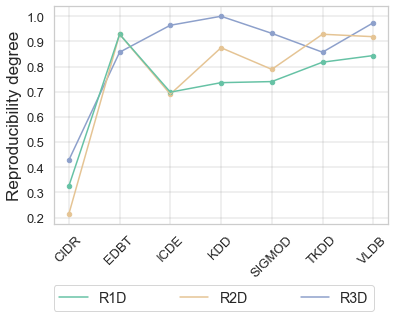

In [298]:

scatter_repro_venue = df[['venue', 'method_repro', 'data_repro',
                    'experiment_repro']].groupby('venue').aggregate('mean').dropna().reset_index()

ax1 = scatter_repro_venue.plot.scatter(x='venue', y='method_repro',  c=cmap(2))
scatter_repro_venue.plot.line(x='venue', y='method_repro', ax=ax1, color=[cmap(2)])

scatter_repro_venue.plot(x='venue', y='data_repro', kind='scatter', ax=ax1, c=cmap(6))
scatter_repro_venue.plot(x='venue', y='data_repro', ax=ax1, color=[cmap(6)], fontsize=13)

scatter_repro_venue.plot.scatter(x='venue', y='experiment_repro', ax=ax1, c=cmap(0))
scatter_repro_venue.plot.line(x='venue', y='experiment_repro', ax=ax1, color=[cmap(0)])

ax1.set_xlabel('')
ax1.set_ylabel('Reproducibility degree', size='medium')
ax1.set_xticklabels(ax1.get_xticklabels(), rotation=45)

ax1.grid(color='grey', linestyle='-', linewidth=0.25)

h, l = ax1.get_legend_handles_labels()
h = [h[2], h[1], h[0]]
l = [l[2], l[1], l[0]]

ax1.legend(h, list(map(lambda x: repro_dict[x], l)),loc=(0, -0.4), ncol=3,
           fontsize='small', mode='expand')

plt.savefig('plots/repro-scatterplot-venue.pdf', dpi=300, bbox_inches='tight')

## Year evolution of RxD

'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.


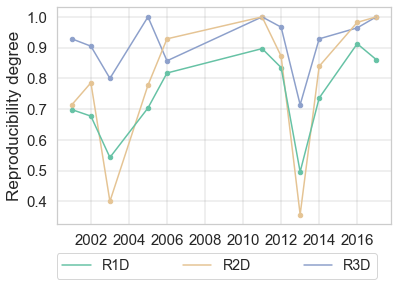

In [297]:
plt.rcParams.update({'font.size': 17})

scatter_repro = df[['year', 'method_repro', 'data_repro',
                    'experiment_repro']].groupby('year').aggregate('mean').dropna().reset_index()
# display(scatter_repro)

ax1 = scatter_repro.plot.scatter(x='year', y='method_repro',  c=cmap(2))
scatter_repro.plot.line(x='year', y='method_repro', ax=ax1, color=[cmap(2)])

scatter_repro.plot(x='year', y='data_repro', kind='scatter', ax=ax1, c=cmap(6))
scatter_repro.plot(x='year', y='data_repro', ax=ax1, color=[cmap(6)], fontsize=15)

scatter_repro.plot.scatter(x='year', y='experiment_repro', ax=ax1, c=cmap(0))
scatter_repro.plot.line(x='year', y='experiment_repro', ax=ax1, color=[cmap(0)])

ax1.set_xlabel('')
ax1.set_ylabel('Reproducibility degree', size='medium')
# ax1.set_xticklabels(ax1.get_xticklabels(), rotation=30)

ax1.grid(color='grey', linestyle='-', linewidth=0.25)

h, l = ax1.get_legend_handles_labels()
h = [h[2], h[1], h[0]]
l = [l[2], l[1], l[0]]

ax1.legend(h, list(map(lambda x: repro_dict[x], l)), loc=(0, -0.25), ncol=3,
           fontsize='small', mode='expand')

plt.savefig('plots/repro-scatterplot.pdf', dpi=300, bbox_inches='tight')

## Percentage of the truth values of each variable per task

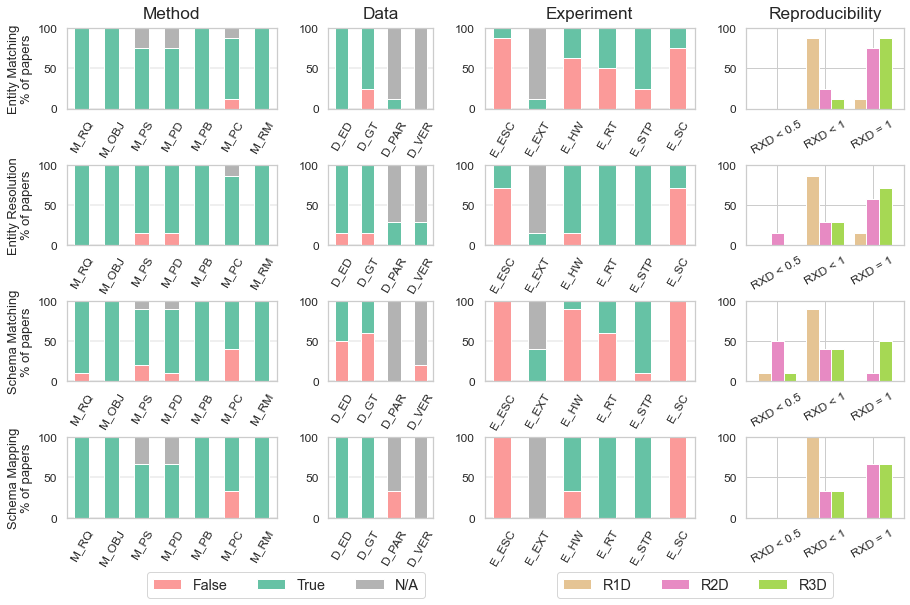

In [136]:


# order = ['experiment_repro', 'data_repro', 'method_repro']

# repro_per_task_transpose = pd.melt(repro_per_task, ['task']).pivot(columns='task', index='variable')['value'].loc[order]

cc = [False, True, 'N/A']
for c in cc:
    em[c] = em[c].transform(lambda x: x * 100 / (task_count['EM']))
    er[c] = er[c].transform(lambda x: x * 100 / (task_count['ER']))
    smat[c] = smat[c].transform(lambda x: x * 100 / (task_count['SMAT']))
    smap[c] = smap[c].transform(lambda x: x * 100 / (task_count['SMAP']))


sns.set(style="whitegrid", font_scale=1)

fig = plt.figure(figsize=(15, 9))
fig.subplots_adjust(wspace=0.3, hspace=0.7)

cols = 4
rows = 4
ylabel_font = 13

spec = GridSpec(ncols=4, nrows=4, width_ratios=[2, 1, 2, 1.5], height_ratios=[2, 2, 2, 2])

axs = list()
for i in range(0, cols * rows, cols):
    ax = list()
    for j in range(i, i + cols):
        ax.append(fig.add_subplot(spec[j]))
    axs.append(ax)


def barplot_per_repro(data, repro_data, axis, task):
    fontsize = 12
    
    ddf = data[data['repro'] == 'data'].drop(['repro'], axis=1)
    mdf = data[data['repro'] == 'method'].drop(['repro'], axis=1)
    edf = data[data['repro'] == 'experiment'].drop(['repro'], axis=1)
        
    mdf.plot(x='variable', kind='bar', ax=axis[0], stacked=True, fontsize=fontsize,
             color=[cmap_paired(4), cmap(0), cmap(7)])
    ddf.plot(x='variable', kind='bar', ax=axis[1], stacked=True, fontsize=fontsize, 
             color=[cmap_paired(4), cmap(0), cmap(7)])
    edf.plot(x='variable', kind='bar', ax=axis[2], stacked=True, fontsize=fontsize,
             color=[cmap_paired(4), cmap(0), cmap(7)])
    repro_data.plot(x='intervals', kind='bar', ax=axis[3], fontsize=fontsize, 
                     color=[cmap(6), cmap(3), cmap(4)], width=0.8)
    
    for ax in axis[:-1]:
        ax.grid(color='grey', linestyle='-', linewidth=0.25)
        ax.set_xlabel('')
        ax.set_ylabel('{}\n% of papers'.format(task), fontsize=ylabel_font)
        ax.set_xticklabels(list(map(lambda x: xticklabels[x.get_text()], ax.get_xticklabels())), rotation='60')
        ax.set_axisbelow(True)
        ax.set_ylim([0, 100])
        ax.get_legend().remove()
        
    for ax in axis[1:]:
        ax.set_ylabel('')        
    

barplot_per_repro(em, repro_count_em, axs[0], 'Entity Matching')
barplot_per_repro(er, repro_count_er, axs[1], 'Entity Resolution')
barplot_per_repro(smat, repro_count_smat,  axs[2], 'Schema Matching')
barplot_per_repro(smap, repro_count_smap, axs[3], 'Schema Mapping')

title_padding = 10
axs[0][0].set_title('Method', fontsize='x-large', pad=title_padding)
axs[0][1].set_title('Data', fontsize='x-large', pad=title_padding)
axs[0][2].set_title('Experiment', fontsize='x-large', pad=title_padding)
axs[0][3].set_title('Reproducibility', fontsize='x-large', pad=title_padding)


for i, task in enumerate(tasks):
    axs[i][3].set_ylim([0, 100])
    axs[i][3].set_xticklabels(['RXD < 0.5', 'RXD < 1', 'RXD = 1'], rotation=30)
    axs[i][3].set_xlabel('')
    axs[i][3].get_legend().remove()


h, l = axs[0][0].get_legend_handles_labels()
# lgd = plt.legend(loc=(-1.83, -0.83), ncol=3, fontsize='small', mode='expand')
lgd = plt.legend(h, l, loc=(-3.8, -1), ncol=3, fontsize='large')

axs[0][3].legend(loc=(-1.2, -6.1), ncol=3, fontsize='large')

# plt.savefig('plots/distribution-task-variable-all.pdf', dpi=300, bbox_extra_artists=(lgd,), bbox_inches='tight')


## Evolution of R1D, R2D, R3D per task

'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches

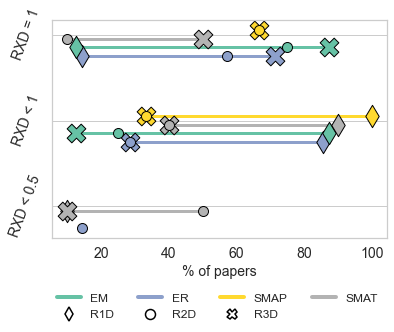

In [142]:
def make_data(dataframe):
    all_df = list()
    for i, task in enumerate(tasks):
        aux = dataframe.reset_index().drop(['intervals'], axis=1)[['index', task]]
        aux['index'] = aux['index'].apply(lambda x: 2 * x + i * 2 / 10)
        all_df.append(aux)
        
    return all_df

r3 = make_data(method_per_task)
r2 = make_data(data_per_task)
r1 = make_data(experiment_per_task)

fontsize=14

fig, ax = plt.subplots()  
for i, task in enumerate(tasks):
    r1[i].plot(x=task, y='index', kind='scatter', c=task_color[task], marker='d', 
                edgecolor='black', linewidth='1', s=250, ax=ax, fontsize=fontsize, zorder=2)
    r2[i].plot(x=task, y='index', kind='scatter', c=task_color[task], marker='o',
               edgecolor='black', linewidth='1', s=100, ax=ax, fontsize=fontsize, zorder=3)
    r3[i].plot(x=task, y='index', kind='scatter', c=task_color[task], marker='X', 
                edgecolor='black', linewidth='1', s=350, ax=ax, fontsize=fontsize, zorder=2)

    x_r1 = r1[i][task].to_numpy()
    x_r2 = r2[i][task].to_numpy()
    x_r3 = r3[i][task].to_numpy()
    y_vals = r1[i]['index'].to_numpy()

    for j in range(len(x_r1)):
        idx = j
        plt.plot([x_r1[idx], x_r2[idx], x_r3[idx]], [y_vals[idx], y_vals[idx], y_vals[idx]], 
                 color=task_color[task], linewidth=3, zorder=1) 
        
ax.set_xlabel('% of papers', fontsize=fontsize) 
ax.set_ylabel('')
ax.set_yticks([0.5, 2.5, 4.5])
ax.set_yticklabels(['RXD < 0.5', 'RXD < 1', 'RXD = 1'], rotation=70, va='center')

ax.grid(axis='x')


plt.legend(handles=[Line2D([], [], color= task_color['EM'], linestyle='-', linewidth=4, label='EM'),
                   Line2D([], [], marker='d', markeredgecolor='black', color='white', markeredgewidth=1.5,
                          linestyle='None', markersize=10, label='R1D'),
                   Line2D([], [], color= task_color['ER'], linestyle='-', linewidth=4, label='ER'),
                   Line2D([], [], marker='o', markeredgecolor='black', color='white', markeredgewidth=1.5,
                          linestyle='None', markersize=10, label='R2D'),
                   Line2D([], [], color=task_color['SMAP'], linestyle='-', linewidth=4, label='SMAP'),
                   Line2D([], [], marker='X', markeredgecolor='black', color='white', markeredgewidth=1.5,
                          linestyle='None', markersize=10, label='R3D'),
                   Line2D([], [], color=task_color['SMAT'], linestyle='-', linewidth=4, label='SMAT')],
                ncol=4, loc=(0, -0.4), fontsize='medium', frameon=False)

# plt.savefig('plots/interval-tasks.pdf', dpi=300, bbox_inches='tight')



## Percentage of R1D, R2D, R3D

,interval,variable,value
0,"(0.0, 0.5]",method_repro,3.6
1,"(0.5, 0.99]",method_repro,28.6
2,"(0.99, 1.0]",method_repro,67.9
3,"(0.0, 0.5]",data_repro,21.4
4,"(0.5, 0.99]",data_repro,32.1
5,"(0.99, 1.0]",data_repro,46.4
6,"(0.0, 0.5]",experiment_repro,3.6
7,"(0.5, 0.99]",experiment_repro,89.3
8,"(0.99, 1.0]",experiment_repro,7.1


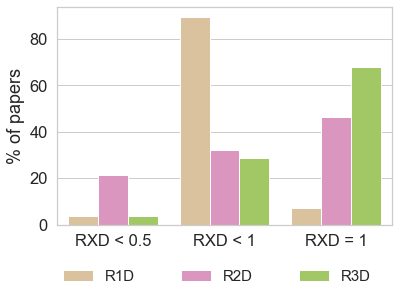

In [160]:
display(pd.melt(pctg_rd, ['interval']))

sns.set(style="whitegrid", font_scale=1.5)
ax = sns.barplot(x='interval', y='value', hue='variable', data=pd.melt(pctg_rd, ['interval']), 
            hue_order=['experiment_repro', 'data_repro', 'method_repro'], palette=[cmap(6), cmap(3), cmap(4)])

ax.set_xticklabels(['RXD < 0.5', 'RXD < 1', 'RXD = 1'])
ax.set_xlabel('')
ax.set_ylabel('% of papers')

handles, labels = ax.get_legend_handles_labels()
ax.legend(handles, ['R1D', 'R2D', 'R3D'], loc=(0,-0.3), ncol=3, fontsize='small', mode='expand', frameon=False)

plt.savefig('plots/barchart-repro.pdf', dpi=300, bbox_inches='tight')
